In [1]:
#load modules
print('loading modules...')
import numpy as np
import basic
import pickle
import curvedsky
#import cmb
import healpy as hp
import pymaster as nmt
import matplotlib.pyplot as plt

##########################################################################

import os,sys
import pylab as pl
import numpy as np
import lenspyx
import healpy as hp

import pysm3
import pysm3.units as u


camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))    
sys.path.insert(0,camb_path)

import camb
from camb import model, initialpower ,correlations

from scipy.special import factorial

sys.path.append('./components')

loading modules...


In [5]:
############################  MAP SIMULATION  ############################
#load modules
print('loading modules...')
import numpy as np
import basic
import pickle
import curvedsky
#import cmb
import healpy as hp
import pymaster as nmt
import matplotlib.pyplot as plt

##########################################################################

import os,sys
import pylab as pl
import numpy as np
import lenspyx
import healpy as hp

sys.path.append("/root/Testarea/prototype/BACKTOFUTURE")

from noise_making import *
from utils_mine import *
from phi_noise_making import *
from generate_map import *
from lenspyx.utils import camb_clfile
from lenspyx.utils_hp import synalm, almxfl, alm2cl

camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))    
sys.path.insert(0,camb_path)



import camb
from camb import model, initialpower ,correlations

from scipy.special import factorial

import pymaster as nm


sys.path.append("/root/Testarea/prototype/Foreground")
from utils_mine import *
lmax=1000
import pysm3.units as u
import pymaster as nmt
# CMB
cl = camb_clfile('/root/download/plancklens/plancklens/data/cls/FFP10_wdipole_lenspotentialCls.dat',lmax+100)   #l,TT,EE,BB,TE,PP,TP,EP

np.random.seed(1)
tlm_unl = hp.synalm(cl['tt'], lmax=lmax, mmax=lmax)
elm_unl = hp.synalm(cl['ee'], lmax=lmax, mmax=lmax)
blm_unl = hp.synalm(cl['bb'], lmax=lmax, mmax=lmax)

loading modules...


In [131]:
def noise(nlev, nside,  seed=0, fwhm_f=None):   #The inhomogeneous instrumental noises is generated based on AliCPT noise variance map.
    """ Noise simulations, we include
            - white noise
            - noise realization according to given noise variance map
            - noise realization and combination of multi-channels

        * nlev      : it depends ...,输入T的,单位muK-pix
        * nside     : nside
        * savePath  : directory to save data
        * seed      : random seed
        * fwhm_f    : only for multi-channel combination

        All AliCPT's detectors are polarized and thus for simplicity
        nlev_Q = nlev_T * sqrt(2)
    """
    #assert isinstance(nlev, list or float or int)   #检查输入的nlev数据类型
    npix = hp.nside2npix(nside)
    fname = 'map_noise_nside%d_%04d.fits'

    np.random.seed(seed)
    m = np.random.normal(size=(3, npix)) * nlev \
                * np.array([1, 2 ** 0.5, 2 ** 0.5]).reshape(3,1)     #三行分别是T,Q,U的
    #variance map 里存的不是variance,而是standard deviation(标准差)，这里生成了符合noise标准差的高斯分布的随机数，得到variance map
    return m


def homo_noise(nlev, nside, seed=0, fwhm_f=None):

    nside = nside
    lmax = 3*nside-1
    npix = hp.nside2npix(nside)

    uKamin2uKpix = lambda n, npix : n / np.sqrt((360 * 60) ** 2 / np.pi / npix)  # 1° = pi/180 rad, 1' (arcmin) = pi/180/60 rad, 见PLANCK2015 (A.7)
    uKpix2uKamin = lambda n, npix : n * np.sqrt((360 * 60) ** 2 / np.pi / npix)
    noise_pix = uKamin2uKpix(nlev, npix)  #muK-pix
    noise_map = noise(noise_pix,nside,seed=seed)    #noise map
    return noise_map


def obs_noise(nlev, nside, beam, seed=0, N_red_T=None, l_knee_T=None, alpha_knee_T=None, n_red_P=None, l_knee_P=None, alpha_knee_P=None, if_red=False, scale_factor = 2):
    """
    Generate 1/f noise and white noise, Gaussian realization from N_noise = N_red * (l / l_knee)**alpha_knee + N_white.

    !!!!!!!!!!!!!!          Notice:         !!!!!!!!!!!!!!!

    since the limited lmax of a healpy map (the limited resolution eliminate smaller modes, which should also exist in the pixel domain noise), 
    you are adviced to first generate a 2*nside map (or larger), then decrease to nside. 
    Otherwise, the generated noise map have a correct noise power, but will be with smaller sigma_pixel compared to theory value, a scale factor (theory / sim) is approximately as follows:

    Original nside      ->      Desired output nside        : 1.160
    nside               ->      nside                       : 1.160
    2*nside             ->      nside                       : 1.015  (recommended)
    4*nside             ->      nside                       : 1.009  (recommended)
    8*nside             ->      nside                       : 1.004

    We see at least a 2*nside map is needed to get a reasonable noise map.

    !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    

    
    * nlev : noise level of white noise in uK-arcmin.
    * N_red_T : 1/f noise power for temperature, in uK^2-s
    * l_knee_T : Specific scale where white noise becomes dominant.
    * alpha_knee_T : Power index control the decay of 1/f noise .
    * n_red_P : 1/f noise level for polarization, in uK-arcmin. If None, it will be set to nlev.
    * l_knee_P : Specific scale where white noise becomes dominant.
    * alpha_knee_P : Power index control the decay of 1/f noise .
    * if_red : If True, include 1/f noise, otherwise only white noise.
    * scale_factor : first generate a scale_factor*nside map, then decrease to nside, the larger the better.

    """

    lmax = 3 * (nside * scale_factor) -1 
    l = np.arange(1,lmax+1)
    N_white = (np.pi/(60*180) * nlev) ** 2

    if if_red:
        if n_red_P is not None:
            N_red_pol = (np.pi/(60*180) * n_red_P) ** 2
        else:
            N_red_pol = N_white
        N_red_tem = N_red_T
    else:
        N_red_pol = 0
        N_red_tem = 0
        l_knee_P = 1
        l_knee_T = 1
        alpha_knee_P = 1
        alpha_knee_T = 1

    bl2 = hp.gauss_beam(np.deg2rad(beam/60), lmax=3*2048-2)**2
    
    N_noise_pol = 2 * (N_red_pol * (l/l_knee_P)**alpha_knee_P + N_white)/bl2
    N_noise_tem = (N_red_tem * (l/l_knee_T)**alpha_knee_T + N_white)/bl2

    #np.random.seed(seed)
    #noise_maps = hp.synfast([N_noise_tem, N_noise_pol, N_noise_pol], nside * scale_factor, pol=False, new=True)
    #noise_maps = np.array([hp.ud_grade(noise_maps[i], nside) for i in range(3)])

    #return noise_maps
    return N_noise_pol, N_noise_tem

In [142]:
from lenspyx.utils import camb_clfile

cl = camb_clfile('/root/download/plancklens/plancklens/data/cls/FFP10_wdipole_lensedCls.dat', 3*2048-2)

In [132]:
nlev = [52, 27, 5.8, 6.3, 15, 37]  # uK-arcmin
theta_ac = [7.4, 5.1, 2.2, 1.4, 1.0, 0.9]
seed = [24, 25, 26, 27, 28, 29]
N_red_T_s = [100, 39, 230, 1500, 17000, 31000]
N_red_T = [value / (8760 * 3600) for value in N_red_T_s]
l_knee_T=[1000, 1000, 1000, 1000, 1000, 1000]
alpha_knee_T=[-3.5, -3.5, -3.5, -3.5, -3.5, -3.5]
n_red_P = [52, 27, 5.8, 6.3, 15, 37]
l_knee_P = [700, 700, 700, 700, 700, 700]
alpha_knee_P = [-1.4, -1.4, -1.4, -1.4, -1.4, -1.4]

freq = [27, 39, 93, 145, 225, 280]

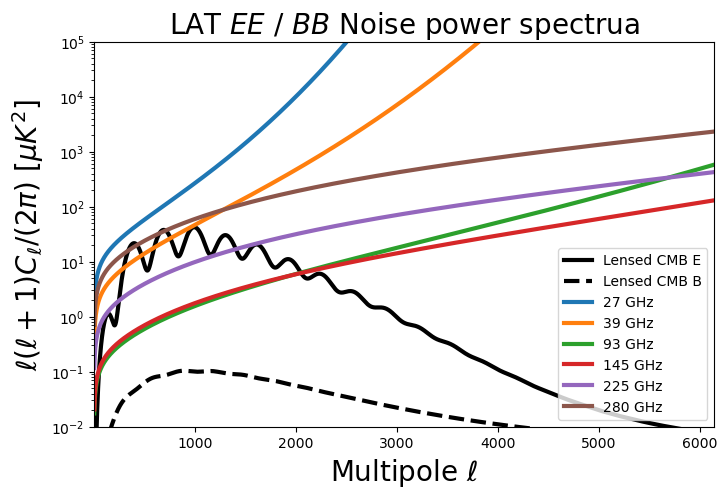

In [146]:
l = np.arange(1, 3*2048)
fac = l * (l+1) / 2 / np.pi

plt.figure(figsize=(8,5))
plt.semilogy(cl['ee'] * fac, 'k', label='Lensed CMB E', linewidth=3)
plt.semilogy(cl['bb'] * fac, 'k--', label='Lensed CMB B', linewidth=3)

for i in range(6):
    nlpp, nltt = obs_noise(nlev[i], 2048, theta_ac[i], seed=0, N_red_T=N_red_T[i], l_knee_T=l_knee_T[i], alpha_knee_T=alpha_knee_T[i], n_red_P=n_red_P[i], l_knee_P=l_knee_P[i], alpha_knee_P=alpha_knee_P[i], if_red=1, scale_factor = 1)
    plt.semilogy(nlpp * fac, label=f'{freq[i]} GHz', linewidth=3)
    #plt.loglog(nltt, label='T')

plt.ylim(1e-2,1e5)
plt.xlim(1, 6144)
plt.legend()
plt.xlabel('Multipole $\ell$',fontsize=20)
plt.ylabel('$ \ell(\ell+1) C_{\ell} / (2 \pi) \ [\mu K^2]$',fontsize=20)
plt.title('LAT $EE$ / $BB$ Noise power spectrua',fontsize=20)
plt.savefig('noise_lat_p.pdf', dpi=300)

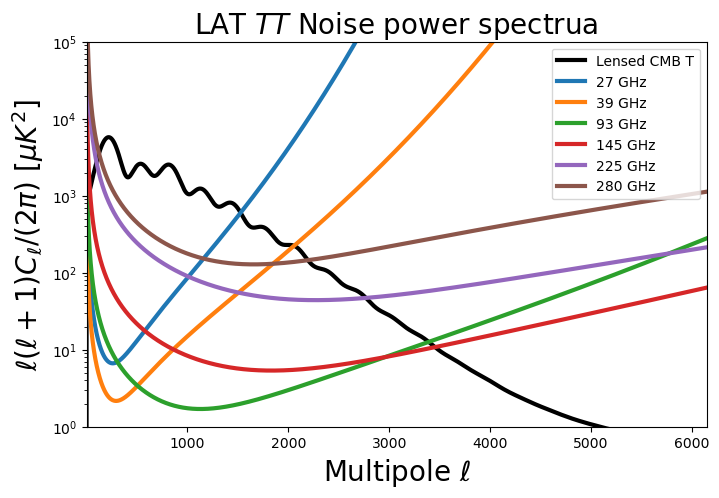

In [148]:
l = np.arange(1, 3*2048)
fac = l * (l+1) / 2 /np.pi

plt.figure(figsize=(8,5))
plt.semilogy(cl['tt'] * fac, 'k', label='Lensed CMB T', linewidth=3)

for i in range(6):
    nlpp, nltt = obs_noise(nlev[i], 2048, theta_ac[i], seed=0, N_red_T=N_red_T[i], l_knee_T=l_knee_T[i], alpha_knee_T=alpha_knee_T[i], n_red_P=n_red_P[i], l_knee_P=l_knee_P[i], alpha_knee_P=alpha_knee_P[i], if_red=1, scale_factor = 1)
    plt.semilogy(nltt * fac, label=f'{freq[i]} GHz', linewidth=3)

plt.ylim(1,1e5)
plt.xlim(1, 6144)
plt.legend()
plt.xlabel('Multipole $\ell$',fontsize=20)
plt.ylabel('$ \ell(\ell+1) C_{\ell} / (2 \pi) \ [\mu K^2]$',fontsize=20)
plt.title('LAT $TT$ Noise power spectrua',fontsize=20)
plt.savefig('noise_lat_t.pdf', dpi=300)